In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import pymc3 as pm
from datetime import datetime, date

%load_ext autoreload
%autoreload 2
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

/Users/maer3/anaconda/envs/mia-stats/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [16]:
def clean_column_names(df):
    colnames = [col.lower().replace(' ', '_') for col in df.columns]
    df.columns = colnames
    return df

In [18]:
data = pd.read_csv('biofilm_2018_all.csv')
data = clean_column_names(data)

# Add a date column.
data['date'] = pd.to_datetime(data[['year', 'month', 'day']])
data['date_coded'] = pd.Categorical(data['date']).codes
data['isolate_coded'] = pd.Categorical(data['isolate']).codes
data.sample(5)

,isolate,st,replicate,od600,od570,reblanked_od,normalized_od570,month,day,year,expt,date,date_coded,isolate_coded
213,85,4,10,0.470,0.581,NaN,1.236170,1,12,2018,4,2018-01-12,2,6
245,90,55,6,0.511,0.230,NaN,0.450098,1,19,2018,5,2018-01-19,3,8
168,90,55,1,0.511,0.303,NaN,0.592955,1,12,2018,4,2018-01-12,2,8
206,85,4,3,0.458,0.345,NaN,0.753275,1,12,2018,4,2018-01-12,2,6
198,16,4,7,0.504,0.294,NaN,0.583333,1,12,2018,4,2018-01-12,2,2


In [19]:
data.describe()

,isolate,st,replicate,od600,od570,reblanked_od,normalized_od570,month,day,year,expt,date_coded,isolate_coded
count,558.000000,558.000000,558.000000,558.000000,558.000000,36.000000,558.000000,558.000000,558.000000,558.0,558.000000,558.000000,558.000000
mean,72.129032,38.451613,5.822581,0.525238,0.515093,0.328944,1.008435,1.193548,13.193548,2018.0,2.707885,2.903226,6.290323
std,41.493802,20.538801,3.387970,0.072944,0.476524,0.315798,0.997252,0.395433,7.174548,0.0,1.323307,1.400676,4.325817
min,11.000000,4.000000,1.000000,0.280000,0.057000,0.095333,0.103636,1.000000,2.000000,2018.0,1.000000,0.000000,0.000000
25%,16.000000,4.000000,3.000000,0.477250,0.217000,0.163833,0.392569,1.000000,8.000000,2018.0,1.000000,2.000000,2.000000
50%,85.000000,48.000000,5.000000,0.513000,0.334000,0.226833,0.614992,1.000000,12.000000,2018.0,3.000000,3.000000,6.000000
75%,100.000000,55.000000,9.000000,0.558000,0.579500,0.291083,1.140915,1.000000,19.000000,2018.0,4.000000,4.000000,10.000000
max,129.000000,55.000000,12.000000,0.822000,2.690000,1.371333,6.255814,2.000000,25.000000,2018.0,5.000000,5.000000,14.000000


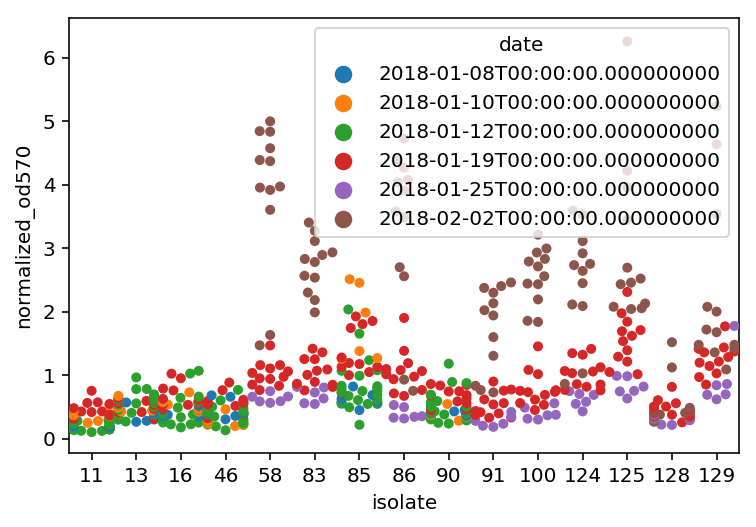

In [20]:
import seaborn as sns
sns.swarmplot(x='isolate', y='normalized_od570', hue='date', data=data)

Based on this, there is a clear batch effect based on measurement dates, and thus those must be controlled for or at least modelled.

The way I'll approach this is as follows:

1. Assume each isolate has a "true" value that is estimated. 
1. Assume each batch of measurements shifts the value off by the true by some amount. Estimate the shift.

In other words, for a single isolate, let $ \mu_{isolate} $ be the `normalized_od570` for that isolate. Therefore, the measured normalized OD570 is the sum of the true OD570 + some shift due to batch effects, $ \beta $.

$ \mu_{measured} = \mu_{truth} + \beta_{date}$

The goal is to estimate $ \mu_{truth} $ from the data. Therefore:

$ \mu_{truth} = \mu_{measured} - \beta_{date} $

Now, because all isolates have been measured on the date 2018-01-19 (red dots), let's estimate the "shift" from that date as a way of controlling for batch effects. (The assumption I'm making here is that the shift from the red dots is a good estimator for the batch effects.)

In [62]:
normalized_od570_redbatch_mean = data.groupby(['date', 'isolate']).mean().loc['2018-01-19'].reset_index()[['isolate', 'normalized_od570']].set_index('isolate').to_dict()['normalized_od570']
normalized_od570_redbatch_mean

{11: 0.46845110866666667,
 13: 0.49919219141666665,
 16: 0.6658424040833334,
 46: 0.5639505585833334,
 58: 1.0252357000833334,
 83: 1.0527076430833333,
 85: 1.3338977914166668,
 86: 1.06630180925,
 90: 0.6743760021666666,
 91: 0.5362154760833334,
 100: 0.7825275625833333,
 124: 1.0351084094166667,
 125: 1.5539503751666663,
 128: 0.4755468185833334,
 129: 1.2541140458333333}

In [76]:
shifts = []
for r, d in data.iterrows():
    shift = d['normalized_od570'] - normalized_od570_redbatch_mean[d['isolate']]
    shifts.append(shift)
data['shift'] = shifts
# sns.swarmplot(x='isolate', y='shift', hue='date', data=data)
data

,isolate,st,replicate,od600,od570,reblanked_od,normalized_od570,month,day,year,expt,date,date_coded,isolate_coded,shift
0,11,55,1,0.517,0.097,NaN,0.187621,1,8,2018,1,2018-01-08,0,0,-0.280830
1,11,55,2,0.524,0.114,NaN,0.217557,1,8,2018,1,2018-01-08,0,0,-0.250894
2,11,55,3,0.502,0.102,NaN,0.203187,1,8,2018,1,2018-01-08,0,0,-0.265264
3,11,55,4,0.477,0.078,NaN,0.163522,1,8,2018,1,2018-01-08,0,0,-0.304929
4,11,55,5,0.514,0.099,NaN,0.192607,1,8,2018,1,2018-01-08,0,0,-0.275844
5,11,55,6,0.509,0.100,NaN,0.196464,1,8,2018,1,2018-01-08,0,0,-0.271987
6,13,4,1,0.538,0.143,NaN,0.265799,1,8,2018,1,2018-01-08,0,1,-0.233393
7,13,4,2,0.433,0.130,NaN,0.300231,1,8,2018,1,2018-01-08,0,1,-0.198961
8,13,4,3,0.457,0.138,NaN,0.301969,1,8,2018,1,2018-01-08,0,1,-0.197223
9,13,4,4,0.562,0.222,NaN,0.395018,1,8,2018,1,2018-01-08,0,1,-0.104174


With this, we can use the shift column as the estimator for the betas.

In [80]:
with pm.Model() as shift_model:
    shape = len(set(data['date_coded']))

    mu_shift = pm.Normal('mu_shift', mu=0, sd=100, shape=shape)
    sd_shift = pm.Exponential('sd_shift', lam=0.5, shape=shape)
    
    mu = mu_shift[data['date_coded']]
    sd = sd_shift[data['date_coded']]
    nu = pm.Exponential('nu', lam=0.5)
    like = pm.StudentT('likelihood', mu=mu, sd=sd, nu=nu, observed=data['shift'])

In [81]:
with shift_model:
    shift_trace = pm.sample(2000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
/Users/maer3/anaconda/envs/mia-stats/lib/python3.6/site-packages/pymc3/model.py:384: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if not np.issubdtype(var.dtype, float):
INFO (theano.gof.compilelock): Refreshing lock /Users/maer3/.theano/compiledir_Darwin-17.4.0-x86_64-i386-64bit-i386-3.6.4-64/lock_dir/lock
100%|██████████| 2500/2500 [00:06<00:00, 364.40it/s]


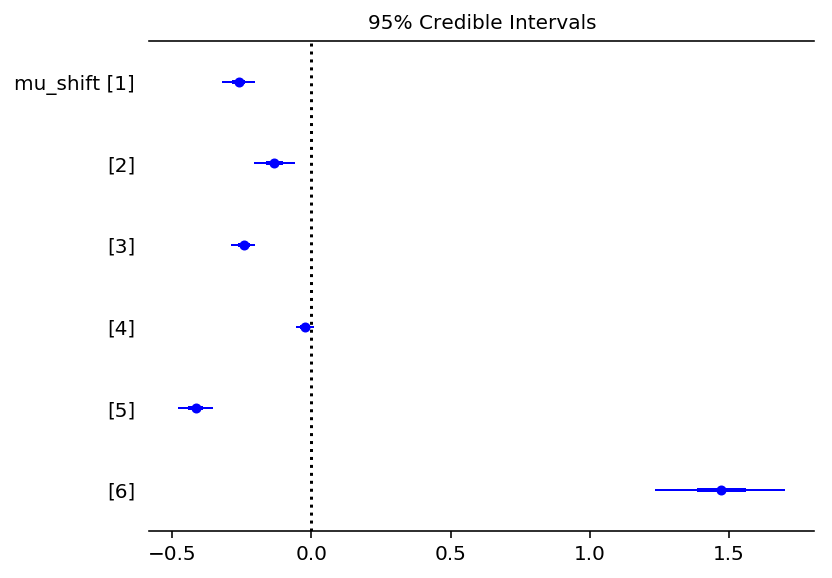

In [82]:
pm.forestplot(shift_trace, varnames=['mu_shift'])

In [5]:
with pm.Model() as nonhierarchical_model:
    shape = len(set(data['Isolate']))
    mu_all = pm.HalfNormal('mu_all', sd=100, shape=(shape,))
    sd_all = pm.Exponential('sd_all', lam=0.5, shape=(shape,))
    nu_all = pm.Exponential('nu', lam=0.5, shape=(shape,))
    mu = mu_all[data['Isolate_coded']]
    sd = sd_all[data['Isolate_coded']]
    nu = nu_all[data['Isolate_coded']]
    like = pm.StudentT('likelihood', mu=mu, sd=sd, nu=nu, observed=data['Normalized OD570'])

In [6]:
with nonhierarchical_model:
    nonhierarchical_trace = pm.sample(2000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
/Users/maer3/anaconda/envs/mia-stats/lib/python3.6/site-packages/pymc3/model.py:384: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if not np.issubdtype(var.dtype, float):
100%|██████████| 2500/2500 [00:09<00:00, 260.93it/s]


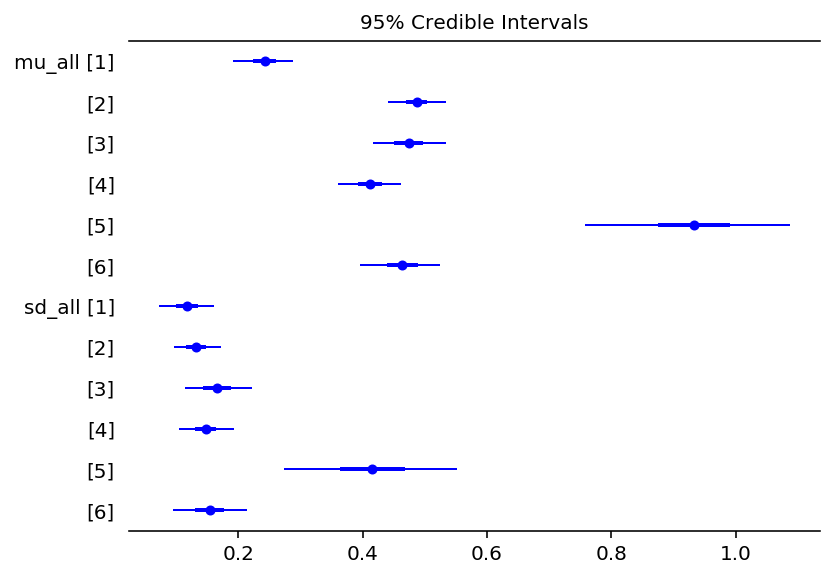

In [8]:
pm.forestplot(nonhierarchical_trace, varnames=['mu_all', 'sd_all'])

In [29]:
# with pm.Model() as halfstudentt_model:
#     shape = len(set(data['Isolate']))
#     nu_all = pm.Exponential('nu_all', lam=0.5, shape=(shape,))
#     sd_all = pm.Exponential('sd_all', lam=0.5, shape=(shape,))
    
#     nu = nu_all[data['Isolate_coded']]
#     sd = sd_all[data['Isolate_coded']]
    
#     like = pm.ChiSquared('like', nu=nu, sd=sd, observed=data['Normalized OD570'])